In [1]:
import scanpy as sc
import numpy as np
import torch
import pandas as pd
from model import ZINBVAE
from dataset import base_genes, get_mech_dataset
from training import train
from utils import sample_zinb, plot_column_densities, set_seed, plot_umap_pca

In [2]:
n_cells=10000
n_genes=20
target_zero_prob=.8
n_epochs = 1000

In [3]:
x, mu_values, theta_values, pi_values = base_genes(n_cells=n_cells, 
                                                    n_genes=n_genes, 
                                                    target_zero_prob=target_zero_prob, 
                                                    mu_bot=1.0, 
                                                    mu_top=10, 
                                                    theta_bot=0.5, 
                                                    theta_top=2.0,
                                                    seed=42)

Actual overall zero proportion: 0.7997


In [4]:
x, mu_values, theta_values, pi_values, mean_weights, dispersion_weights, n_genes = get_mech_dataset(
                                                                                x=x,
                                                                                mu_values=mu_values,
                                                                                theta_values=theta_values,
                                                                                pi_values=pi_values,
                                                                                n_cells=n_cells,
                                                                                n_genes=n_genes,
                                                                                target_zero_prob=target_zero_prob,
                                                                                seeds=[43,11],
                                                                                theta_fixed=True
                                                                            )

In [5]:
adata = sc.AnnData(x)
adata.obs["input_cell"] = pd.Categorical(["1"] * adata.n_obs)

In [6]:
#x[:n_cells//2,:] +=10

In [7]:
n_epochs = 1000
set_seed(3)
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = ZINBVAE(input_dim=x.shape[1], hidden_dim=40, latent_dim=10)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

mean, disp, pi, mu, logvar, z = train(vae, optimizer, x, n_epochs, n_cells, mu_values, 
                                      theta_values, pi_values, seed=11, device=device)


to_numpy = lambda x: x.detach().cpu().numpy() if hasattr(x, 'detach') else np.array(x)
mean, disp, pi, mu, logvar, z = list(map(to_numpy, [mean, disp, pi, mu, logvar, z]))

torch.save(vae.state_dict(), "trained_models/trained_model_state_dict.pth")
torch.save(optimizer.state_dict(), "trained_models/trained_model_optimizer.pth")

Epoch 0, Loss: 8.2245, Mean MSE: 33.8321, Theta MSE: 1.3498, Pi MSE: 0.0811
Epoch 1, Loss: 7.7687, Mean MSE: 33.7277, Theta MSE: 1.3394, Pi MSE: 0.0829
Epoch 2, Loss: 7.4891, Mean MSE: 33.6468, Theta MSE: 1.3421, Pi MSE: 0.0846
Epoch 3, Loss: 7.1114, Mean MSE: 33.5218, Theta MSE: 1.3614, Pi MSE: 0.0872
Epoch 4, Loss: 6.9367, Mean MSE: 33.4262, Theta MSE: 1.3629, Pi MSE: 0.0894
Epoch 5, Loss: 6.6208, Mean MSE: 33.2894, Theta MSE: 1.3562, Pi MSE: 0.0913
Epoch 6, Loss: 6.4080, Mean MSE: 33.2314, Theta MSE: 1.3740, Pi MSE: 0.0933
Epoch 7, Loss: 6.1702, Mean MSE: 33.0844, Theta MSE: 1.3701, Pi MSE: 0.0957
Epoch 8, Loss: 6.0403, Mean MSE: 32.9579, Theta MSE: 1.3696, Pi MSE: 0.0981
Epoch 9, Loss: 5.8792, Mean MSE: 32.8447, Theta MSE: 1.3768, Pi MSE: 0.1008
Epoch 10, Loss: 5.7166, Mean MSE: 32.7989, Theta MSE: 1.3870, Pi MSE: 0.1030
Epoch 11, Loss: 5.5463, Mean MSE: 32.6446, Theta MSE: 1.3799, Pi MSE: 0.1054
Epoch 12, Loss: 5.3874, Mean MSE: 32.5178, Theta MSE: 1.3806, Pi MSE: 0.1078
Epoch 13,

/mnt/data2/home/leonardo/miniconda3/envs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


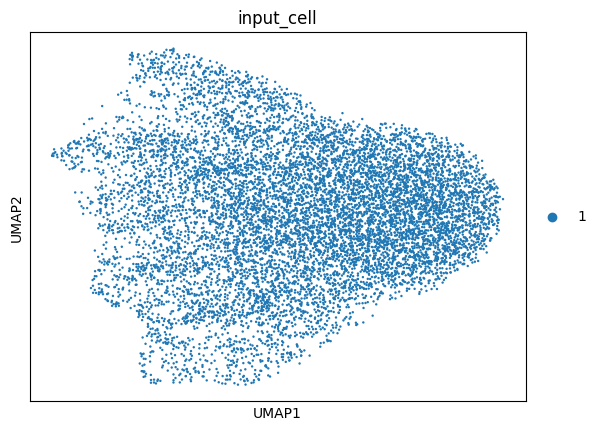

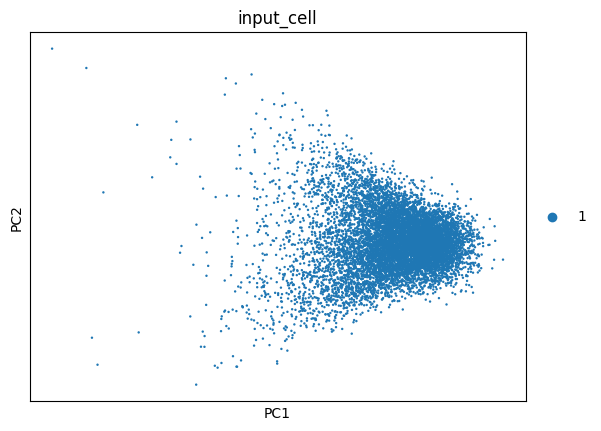

In [8]:
adata_z = sc.AnnData(X=z)
adata_z.obs["input_cell"] = adata.obs["input_cell"].copy()

plot_umap_pca(adata_z, color="input_cell", random_state=0)

In [9]:
zinb_sample = sample_zinb(mean, disp, pi, eps=1e-8, seed=11)

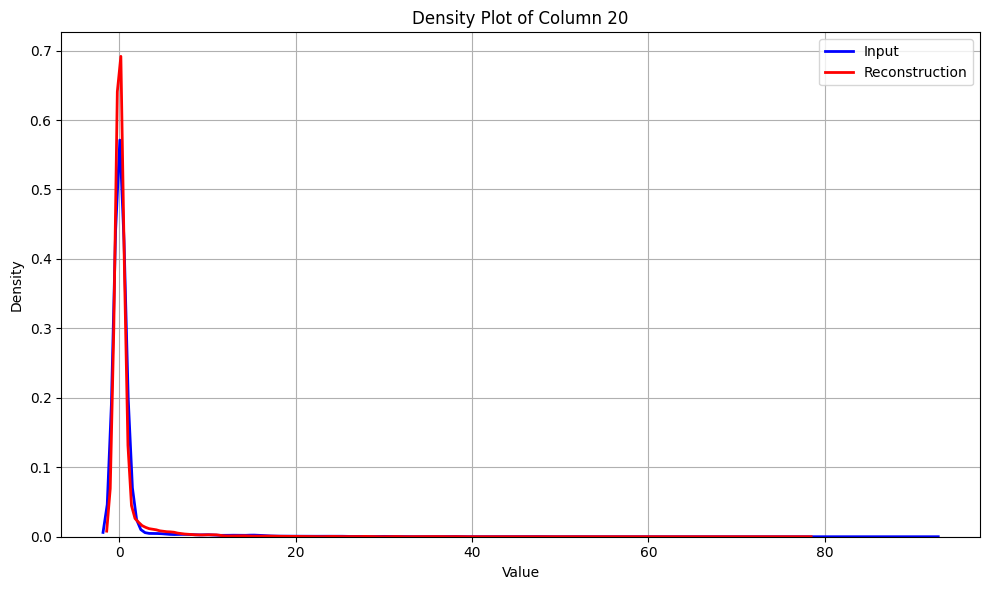

In [10]:
plot_column_densities(matrix1=x, matrix2=zinb_sample, column_index=20, label1='Input', label2='Reconstruction')

In [11]:
# Step 1: Create AnnData for the new observations
new_adata = sc.AnnData(X=zinb_sample)
new_adata.var_names = adata.var_names  # Ensure variable names match
new_adata.obs_names = [f"new_obs_{i}" for i in range(new_adata.n_obs)]

# Step 2: Assign "1" to base_gene for new observations
new_adata.obs["input_cell"] = pd.Categorical(["0"] * new_adata.n_obs)

# Step 4: Concatenate and overwrite
adata = sc.concat([adata, new_adata], axis=0)

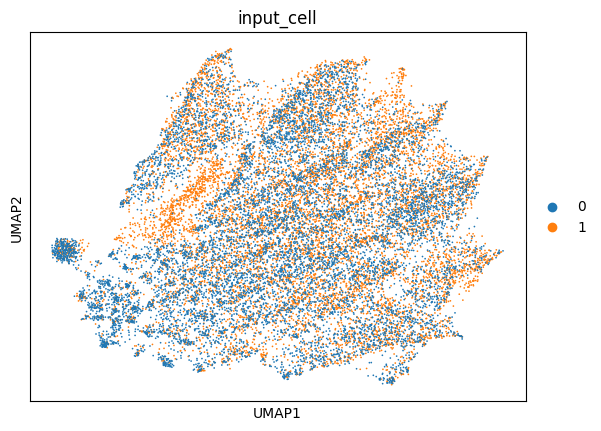

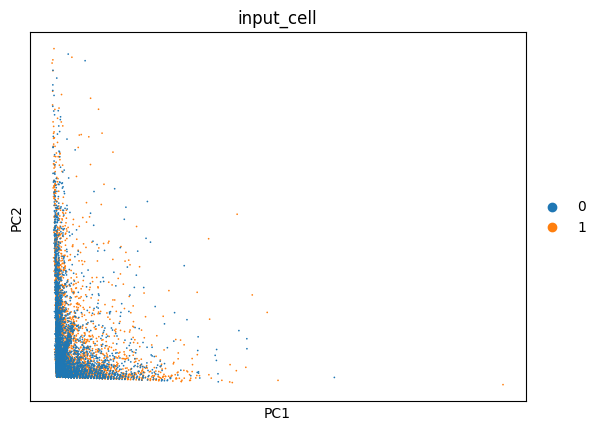

In [12]:
plot_umap_pca(adata, color="input_cell", random_state=0)